<a href="https://colab.research.google.com/github/NganTran-0017/LING5412/blob/main/Classic_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CLASSIC MACHINE LEARNING MODELS
Classic models are often prefered to use for saving computational resources; however, in many cases, they can outperform deep learning models. For example, data is not enough to train or class imbalance. Since our dataset is strongly imbalanced, classic ML models could be a good choice.
We are going to train the following classic models: 

In [1]:
import tarfile
import pandas as pd
import csv
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree          
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm 
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix, recall_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
!pip install imbalanced-learn
import imblearn
# from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import recall_score, roc_auc_score

from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

For this set of classic machine learning model, we will made use of word2vec pretrained embedding model to represent documents.

In [2]:
# Download Word2vec pretrained embedding model
import gensim
import gensim.downloader as api
nlp = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


# **Loading data**

Connects google drive to this notebook to get the dataset, and then unzip it. Then, we load the specified columns (docID, keyword, country, paragraph and label) into the df.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

# Unzip the dataset
!unzip "/content/drive/MyDrive/dontpatrAAonizeme_v1.3.zip" -d "/content/drive/MyDrive/"

Mounted at /content/drive
unzip:  cannot find or open /content/drive/MyDrive/dontpatrAAonizeme_v1.3.zip, /content/drive/MyDrive/dontpatrAAonizeme_v1.3.zip.zip or /content/drive/MyDrive/dontpatrAAonizeme_v1.3.zip.ZIP.


In [4]:
# Opening the file from MyDrive
file = open(r'/content/drive/MyDrive/dontpatronizeme_v1.3/dontpatronizeme_pcl.tsv')
reader = csv.reader(file, delimiter="\t")
data = []
for row in reader:
  data.append(row)

# 
df = pd.DataFrame(data[5:],  columns = ['docID', 'keyword', 'country', 'paragraph', 'label' ] )
df

,docID,keyword,country,paragraph,label
0,@@4703096,immigrant,jm,NBC and Spanish-language Univision both declin...,0
1,@@25567226,in-need,hk,A second T-Home project is being launched in t...,0
2,@@1824078,poor-families,tz,Camfed would like to see this trend reversed ....,4
3,@@1921089,refugee,tz,Kagunga village was reported to lack necessary...,0
4,@@40039380,women,ng,Haruna stressed the need for specific approach...,0
...,...,...,...,...,...
10053,@@16413808,immigrant,my,"To me , I am always mindful that we are dealin...",4
10054,@@8676630,vulnerable,jm,Other themes included promoting the inclusion ...,0
10055,@@7688552,immigrant,gb,It came as the CDU was also humiliated by the ...,0
10056,@@4916290,hopeless,in,"Those were only days of helplessness , she say...",0


# **Exploring data**

**Getting the length of each data instance and plotting its histogram.**

In [5]:
# Length of text
def length (txt):
  length = len(txt.split())
  return length

txt_length = df['paragraph'].apply(lambda x: length(x))
txt_length.sort_values(ascending = False)

3534    1519
6266    1095
8519    1040
4613     772
8819     729
        ... 
1930       4
1385       3
7375       3
5112       3
5742       0
Name: paragraph, Length: 10058, dtype: int64

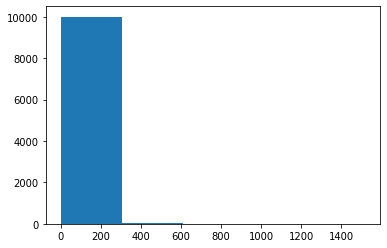

In [6]:
# Plot the histogram of sentence length
plt.hist(txt_length, 5)
plt.show()

Based on this histogram, the majority of the dataset has a length of less than 350. There are around 100 records whose lengths are between 301 and 600. Moreover, based on the descending sort of the length of each data instance shown above, the longest one is 1519 and the second-longest instance is 1095.

**Exploring data distribution over classes**

In [7]:
# Observing labels
df['label'].value_counts()

0    8206
1     906
3     435
4     369
2     142
Name: label, dtype: int64

There are 5 labels in this dataset. The label number represents the degree of patronizing and condescending language (PCL).  Label 0 are sentences that do not contain patronizing nor condescending language, where as Label 4 are sentences with highly PCL. Based on the value counts below, the majority of data is negative with a label 0, whereas only 946 records are positive. Positive data contain labels from 1 to 4.

**Checking missing data**

In [8]:
# Checking for missing values
print('Is null: \n', df.isnull().sum() )

Is null: 
 docID        0
keyword      0
country      0
paragraph    0
label        0
dtype: int64


None of the column contains missing values.

**Converting target variable into binary**

In this project, we choose task 1 that is a binary classification of PCL. Therefore, we convert the labels into 0 and 1, where 0 means negative and 1 means positive. The negative data contain label 0 and label 1 originally, and the positive data contain labels 2 to 4.

0    10058
Name: label, dtype: int64
0    100.0
Name: label, dtype: float64


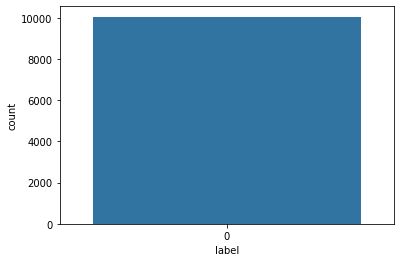

In [22]:
# Convert label data type to string
df['label'] = df['label'].astype(str)

# Converting label to binary
label_dic = {'0':0,
             '1':0,
             '2':1,
             '3':1,
             '4':1}
df['label'] = df['label'].map(label_dic)
print(df['label'].value_counts())
print(df['label'].value_counts()*100/len(df['label']))
sns.countplot(x='label', data=df)
plt.show()

# **Developing models**

Once the data is thoroughly explored, we proceed to partition the shuffled data into training and testing sets with a ratio of 80-20. 

In [10]:
# Splitting the data into training (80%) and test set(20%)
from sklearn.model_selection import train_test_split
X = df['paragraph']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split (X, y, train_size = 0.8, random_state = 42, shuffle = True, stratify=y)
print ('Shapes of X_train, y_train: ', X_train.shape, y_train.shape)
print ('Shapes of X_test, y_test: ', X_test.shape, y_test.shape)
print(y_train.value_counts())

Shapes of X_train, y_train:  (8046,) (8046,)
Shapes of X_test, y_test:  (2012,) (2012,)
0    7289
1     757
Name: label, dtype: int64


## Text representation

As mentioned, we use word2vec pretrained model, specifically continuous-bag-of-word (CBOW) model for representing documents.

In this section, we convert text data to its word embedding vectors. 
Firstly, the data is passed through function w2v_tokenize text, where each data instance is split into sentences, and each sentence is tokenized into words. At the end of this function, a list of words of data instance is returned. We repeat this step for the testing data to get the tokenized test data. 

Then, the tokenized words that we get from the previous step is embedded into its numeric form through function word_averging_list. This function passes a list of tokenized words in each instance to function word_averaging, where data is ---------------------------------------------

In [20]:
# Download and import essential libraries
#!pip install stop-words
#from stop_words import get_stop_words
#stopwords = get_stop_words('en')
# from textblob import Word
import re
import nltk
# nltk.download('wordnet')
# nltk.download('punkt')
import logging

nlp.init_sims(replace=True) # calling for using syn0norm


# Tokenizing the document text, return a list of word for each document
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens

# Defining a function to get pretrained embedding for each token
# and take an average of word2vec embeddings of all tokens in the document 
# as vector representation for that document.
def word_averaging(wv, words):
    all_words, mean = set(), []
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index]) # appending each 300-D embedding for each word
            all_words.add(wv.vocab[word].index)
    if not mean:
        logging.warning("no input %s", words)
        return np.zeros(wv.vector_size,)
    # computing the mean of the embedding list
    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

# Defining a function to stack together all document embeddings into one
def  word_averaging_list(wv, text_list):
   stack = np.vstack([word_averaging(wv, post) for post in text_list ])
   return stack



In [21]:
## Applying the defined function to encode document text with word2vec embedding
# Tokenize texts into words
X_train_tokenized = X_train.apply(lambda x: w2v_tokenize_text(x)).values
X_test_tokenized = X_test.apply(lambda x: w2v_tokenize_text(x)).values

# Embed words into number
X_train_word_average = word_averaging_list(nlp,X_train_tokenized)
X_test_word_average = word_averaging_list(nlp,X_test_tokenized)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.wv.vectors_norm instead).


--------------stack--------- 8046
--------------stack--------- 2012


## Create helper functions

This part creates 2 helper function, where printing_eval_scores is responsible for printing out the model performance and get_roc_curve is responsible for extracting different metrics such as false positive rate (FPR), recall, macro-f1 scores and auc score. These 2 functions take the ground truth labels and predicted labels as inputs.

Since the data is very imbalanced, we decide to use macro-F1 score as a standard metric to compare among the candidate models. Macro-F1 score takes both major class and minor class into account regardless of their sizes. Therefore, using this metric will give us a more precise baseline to compare among the models. 

In [ ]:
## Printing model performance 
# This function takes in the true labels and predicted labels to print out different performance metrics as shown below.
def printing_eval_scores (y_true, y_pred):
  print('accuracy score: {}'.format(sklearn.metrics.accuracy_score(y_true, y_pred)))
  print('precision score: {}'.format(sklearn.metrics.precision_score(y_true, y_pred, average = 'macro', zero_division=1)))
  print('recall score: {}'.format(sklearn.metrics.recall_score(y_true, y_pred,  average = 'macro', zero_division=1)))
  print('F1 score: {}'.format(f1_score(y_true, y_pred,  average = 'macro', zero_division=1)))
  print('\nConfusion Matrix:\n', confusion_matrix(y_true, y_pred))
  print('\n', classification_report(y_true, y_pred))

#-------------------------------------------------------------------------------------
## Get the measurements of ROC curve for each model
# This function takes in the true labels and predicted labels to get FPR, recall, macro F1
# and auc scores. Next, it creates a dictionary containing all these mertrics, and then return this dictionary.
def get_roc_cuve (y_true, y_pred):
  # Get arrays of FPR and recall using roc_curve
  FPR, recall, threshold = sklearn.metrics.roc_curve(y_true, y_pred)

  # Get testing accuracy:
  acc = accuracy_score( y_test,y_pred)

  # Get testing macro-f1:
  f1 = f1_score(y_test, y_pred,  average = 'macro', zero_division=1)

  # Get auc score
  auc = sklearn.metrics.auc(FPR, recall)
  roc = {'fpr': FPR, 'tpr': recall, 'auc': auc, 'accuracy': acc, 'macro-F1': f1}
  return roc

## Creating and training models

As the dataset is highly imbalanced in which the minor class accounts for ..............., we decided to oversample the minor class with SMOTE (Synthetic Minority Oversampling TEchnique). SMOTE is a augmentation technique, generating new examples by synthesizing the original data. 
We use Cross Validation method to train and validate the performance of models over 5 folds. 

In [ ]:
# Define a function for training models with SMOTE and cross validation
def score_model(name,model):
    cv = StratifiedKFold(n_splits=5, random_state=42, shuffle = True)

    oversampler = SMOTE(random_state=42)
    #oversampler = RandomOverSampler(sampling_strategy='minority')
    scores = []
    f1_scores = []
    
    ## on training set, do cv
    for train_fold_index, val_fold_index in cv.split(X_train_word_average, y_train):
        # Get the training data
        X_train_fold, y_train_fold = X_train_word_average[train_fold_index], y_train.iloc[train_fold_index]
        # Get the validation data
        X_val_fold, y_val_fold = X_train_word_average[val_fold_index], y_train.iloc[val_fold_index]

        # Upsample only the data in the training section
        X_train_fold_upsample, y_train_fold_upsample = oversampler.fit_resample(X_train_fold,
                                                                           y_train_fold)
        # Fit the model on the upsampled training data
        model.fit(X_train_fold_upsample, y_train_fold_upsample)
        # Score the model on the (non-upsampled) validation data
        score = accuracy_score(y_val_fold, model.predict(X_val_fold)) 
        f1 = sklearn.metrics.f1_score(y_val_fold, model.predict(X_val_fold),  average = 'macro', zero_division=1)  
        scores.append(score)
        f1_scores.append(f1)
        
    print('Average of acuracy score in training: %s' % np.array(scores).mean())
    print('Average of Macro F1-score in training: %s' % np.array(f1_scores).mean())

    ## on test set
    y_pred = model.predict(X_test_word_average)
    test_score = accuracy_score( y_test,y_pred)
    macro_f1_test = f1_score(y_test, y_pred,  average = 'macro', zero_division=1)
    printing_eval_scores (y_test, y_pred)
    roc = get_roc_cuve(y_test, y_pred)
    report_scores = {'accuracy_folds':np.array(scores),'accuracy_test':test_score, 'macro_f1_test': macro_f1_test, 'y_predicted':y_pred, 'roc': roc }
    return report_scores 

Average of acuracy score in training: 0.7895843643480578
Average of Macro F1-score in training: 0.6328994844641667
accuracy score: 0.794234592445328
precision score: 0.6216037110669317
recall score: 0.7678894316305178
F1 score: 0.6387422020831454

Confusion Matrix:
 [[1459  364]
 [  50  139]]

               precision    recall  f1-score   support

           0       0.97      0.80      0.88      1823
           1       0.28      0.74      0.40       189

    accuracy                           0.79      2012
   macro avg       0.62      0.77      0.64      2012
weighted avg       0.90      0.79      0.83      2012

LR: 0.789584 (0.014373)
Average of acuracy score in training: 0.8992043204181448
Average of Macro F1-score in training: 0.6138473818789001
accuracy score: 0.889662027833002
precision score: 0.6198624955874196
recall score: 0.5620858692718265
F1 score: 0.5767196970558468

Confusion Matrix:
 [[1760   63]
 [ 159   30]]

               precision    recall  f1-score   support

  

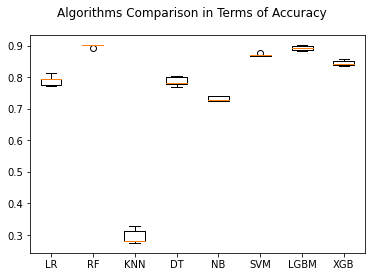

In [ ]:
# Running all models together
# Compare Algorithms

# Create models, and store in a list
models = []
models.append(('LR', LogisticRegression(solver='lbfgs', max_iter=700)))
models.append(('RF', RandomForestClassifier()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(decision_function_shape='ovo', probability=True)))
models.append(('LGBM', LGBMClassifier(objective= 'binary')))
models.append(('XGB', XGBClassifier(eval_metric="mlogloss", objective = "reg:logistic") ))


# Loop over the model list to train and evaluate each model.
results = []
score_test = []
macro_f1 = {}
names = []
rocs = {}
report_scores_all = {}
for name, model in models:
  report_scores = score_model(name, model)
  report_scores_all[name] = report_scores
  results.append(report_scores['accuracy_folds'])
  score_test.append(report_scores['accuracy_test'])
  macro_f1[name] = (report_scores['macro_f1_test'])
  rocs[name] = (report_scores['roc'])
  names.append(name)
  msg = "%s: %f (%f)" % (name, report_scores['accuracy_folds'].mean(), report_scores['accuracy_folds'].std())
  print(msg)


In [ ]:
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Model Comparison on Fold Accuracy')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

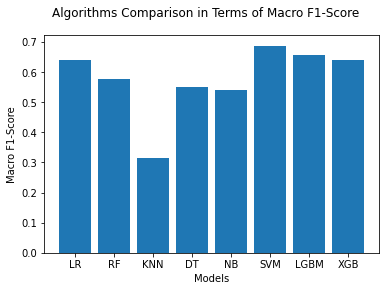

In [ ]:
# boxplot algorithm comparison in terms of Macro F1-Score
fig = plt.figure()
fig.suptitle('Algorithms Comparison in Terms of Macro F1-Score')
ax = fig.add_subplot(111)
plt.bar(macro_f1.keys(), macro_f1.values())
plt.ylabel('Macro F1-Score')
plt.xlabel('Models')
ax.set_xticklabels(names)
plt.show()

#Visualizing all models with ROC curves

The model performances are visualized through an overlaid ROC curves. In this plot, the higher recall and the lower FPR that the model can achieve, the better that model is. A model that randomly classify data is represented as a straight dotted line in black.

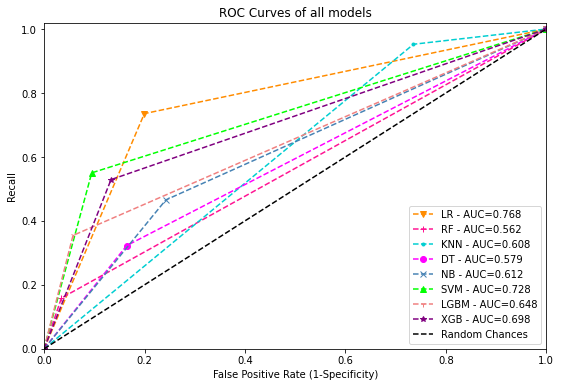

In [ ]:
def graph_multi_ROC (rocs):
  # Set color for each model
  colors = {'LGBM': 'lightcoral','LR': 'darkorange', 'SVM':'lime', 'NB': 'steelblue',
            'XGB': 'purple','DT': 'magenta','RF': 'deeppink','KNN': 'darkturquoise',
            'BERT': 'darkred', 'GPT': 'blue'}
  # Set marker for each model          
  markers = {'LGBM':'1--','LR': 'v--', 'SVM': '^--', 'XGB': '*--', 'DT': 'o--', 'RF': '+--', 'KNN': '.--', 'NB': 'x--', 'BERT':'<--', 'GPT': '>--'}
  
  plt.figure(figsize=(9,6))
  for model in rocs:
    plt.plot( rocs[model]['fpr'], rocs[model]['tpr'], markers[model], color=colors[model], label= model+' - AUC=' + str(rocs[model]['auc'].round(3)) )
  
  plt.plot([0,1], [0,1], 'k--', label='Random Chances')
  plt.xlim([0.0,1.0])
  plt.ylim([0.0,1.02])
  plt.ylabel('Recall')
  plt.xlabel('False Positive Rate (1-Specificity)')
  plt.legend(loc='lower right') 
  plt.title( 'ROC Curves of all models')
  plt.show()

graph_multi_ROC(rocs)

In [ ]:
# Export performance to a txt file
txtfile = open('ML_rocs.txt','w')
for i in rocs.keys():
  txtfile.write(str(i) + '=' + str(rocs[i])+'\n')
  #print(rocs[i])
txtfile.close()

In [ ]:
rocs

{'DT': {'accuracy': 0.7872763419483101,
  'auc': 0.5790937085506477,
  'fpr': array([0.        , 0.16456391, 1.        ]),
  'macro-F1': 0.5493086303448997,
  'tpr': array([0.        , 0.32275132, 1.        ])},
 'KNN': {'accuracy': 0.3290258449304175,
  'auc': 0.6083901470626649,
  'fpr': array([0.        , 0.73560066, 1.        ]),
  'macro-F1': 0.31356047855160807,
  'tpr': array([0.        , 0.95238095, 1.        ])},
 'LGBM': {'accuracy': 0.8871769383697813,
  'auc': 0.6484499937599224,
  'fpr': array([0.        , 0.05759737, 1.        ]),
  'macro-F1': 0.654610036881505,
  'tpr': array([0.        , 0.35449735, 1.        ])},
 'LR': {'accuracy': 0.794234592445328,
  'auc': 0.7678894316305177,
  'fpr': array([0.        , 0.19967087, 1.        ]),
  'macro-F1': 0.6387422020831454,
  'tpr': array([0.        , 0.73544974, 1.        ])},
 'NB': {'accuracy': 0.7301192842942346,
  'auc': 0.6115754889753793,
  'fpr': array([0.        , 0.24245749, 1.        ]),
  'macro-F1': 0.54024395119